In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
datafile = 'OnlineNewsPopularity.csv'
df = pd.read_csv(datafile)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## Class Labels - 4 Classes

In [3]:
# N=4
df['class_N4'] = 0
df.loc[(df[' shares']>=1050) & (df[' shares']<2350), 'class_N4'] = 1
df.loc[(df[' shares']>=2350) & (df[' shares']<7550), 'class_N4'] = 2
df.loc[df[' shares']>=7550, 'class_N4'] = 3

## Feature Engineering

In [4]:
df.columns = df.columns.str.replace(' ', '')
df.loc[:,'No_word'] = df.n_tokens_content.apply(lambda x: 1 if x==0 else 0)
topic_list = list(df.columns[df.columns.str.contains('LDA')])
all_below_point3 = list(df[topic_list][df[topic_list]<0.3].dropna().index)
df.loc[all_below_point3, 'all_topic'] = 1
df['all_topic']= df['all_topic'].fillna(0)

In [5]:
df['all_topic'].value_counts()

0.0    39553
1.0       91
Name: all_topic, dtype: int64

In [6]:
df['No_word'].value_counts()

0    38463
1     1181
Name: No_word, dtype: int64

## Data Cleaning and Data Transformation

In [7]:
#outlier (>1) in var “n_unique_tokens”, “n_non_stop_words”, and “n_non_stop_unique_tokens”, 
#which might be due to typing error. We will remove that observation.
col_list = [4,5,6]
for col in col_list:
    print(df.columns[col])
    df = df[df[df.columns[col]]<1]

n_unique_tokens
n_non_stop_words
n_non_stop_unique_tokens


In [8]:
#Missing values are very troubling in this data set because they are coded as 0. 
#So you have to judge if the 0 are missing or real data. By check the distributions, 
#we found around 3000 observations with missing values in 9 different variables. 
#We will remove all cases with missing values.
col_list = [11,20,44,45,46,48,49,50,53]
for col in col_list:
    print(df.columns[col])
    df = df[df[df.columns[col]]!=0]

average_token_length
kw_max_min
global_subjectivity
global_sentiment_polarity
global_rate_positive_words
rate_positive_words
rate_negative_words
avg_positive_polarity
avg_negative_polarity


In [9]:
#treat skewed data. 
#for those variables with all values bigger than 0, use log
#and other variable with 0, use square root.

col_list = [3,7,8,9,10,22,26,27,28,29,30,39,40,41,42,43,47,60] ######
for col in col_list:
    print(df.columns[col])
    if np.min(df[df.columns[col]]) > 0:
        col_name = 'log_'+df.columns[col]
        df[df.columns[col]] = np.log(df[df.columns[col]])
    else:
        col_name = 'sqrt_'+df.columns[col]
        df[df.columns[col]] = np.sqrt(df[df.columns[col]])   
    if df.columns[col] != ' shares':
        df.rename(columns={df.columns[col]:col_name}, inplace=True)


n_tokens_content
num_hrefs
num_self_hrefs
num_imgs
num_videos
kw_min_max
kw_max_avg
kw_avg_avg
self_reference_min_shares
self_reference_max_shares
self_reference_avg_sharess
LDA_00
LDA_01
LDA_02
LDA_03
LDA_04
global_rate_negative_words
shares


## LGBM Model
### First Round Optimization

In [10]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'log_n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'sqrt_num_hrefs', 'sqrt_num_self_hrefs', 'sqrt_num_imgs',
       'sqrt_num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'sqrt_kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
       'log_kw_max_avg', 'log_kw_avg_avg', 'sqrt_self_reference_min_shares',
       'sqrt_self_reference_max_shares', 'sqrt_self_reference_avg_sharess',
       'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday', 'is_weekend', 'log_LDA_00', 'log_LDA_01',
       'log_LDA_02', 'log_LDA_03', 'log_LDA_04', 'global_subject

In [11]:
target = 'class_N4'

features = ['sqrt_num_hrefs',  
            'sqrt_num_self_hrefs', 
            'average_token_length', 
            'log_kw_max_avg', 
            'log_kw_avg_avg', 
            'weekday_is_tuesday', 
            'weekday_is_friday',  
            'is_weekend', 
            'log_LDA_00', 
            'log_LDA_01',
            'log_LDA_02', 
            'log_LDA_03', 
            'log_LDA_04', 
            'global_subjectivity', 
            'global_sentiment_polarity', 
            'global_rate_positive_words',
            'log_global_rate_negative_words', 
            'rate_positive_words', 
            'avg_positive_polarity', 
            'avg_negative_polarity', 
            'title_subjectivity', 
            'title_sentiment_polarity', 
            
            'all_topic', 
            'No_word',
            
            'n_unique_tokens', 
            'sqrt_self_reference_min_shares', 
           ]

seed = 2021
test_size = 0.2 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

df_X = df[features]
df_y = df[target]

X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                    df_y,
                                                    test_size=test_size,
                                                    random_state=seed,
                                                    stratify=df_y)

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [13]:
# Bayesian Optimization by Hyperopt package
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
from hyperopt.pyll import scope

import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score

In [14]:
def hyperopt_multiclass(param_space, X_train, y_train, num_eval, classifier):
    
    def objective_function_multiclass(params):
        # initialise classifier
        clf = classifier(**params, random_state=1)
        # cross validation + scoring (AUC)
        score = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=kf, error_score='raise').mean()
        # objective is to maximise AUC i.e. minimize -AUC
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    # minimise objective function
    best_param = fmin(objective_function_multiclass, param_space, algo=tpe.suggest, max_evals=num_eval,
                      trials=trials, rstate=np.random.RandomState(1))

    loss = [x['result']['loss'] for x in trials.trials]
    best_param_values = best_param
    return trials, best_param_values

In [15]:
#Define the parameters that will be optimized
num_eval = 10 # should use 50, 100, or more

# setting the range of parameter tuning
LGBM_param_hyperopt = {
    'objective': hp.choice('objective', ['multiclass']),
    #'metric': hp.choice('metric', ['auc']),
    'num_leaves': scope.int(hp.quniform('num_leaves', 200, 500, 1)),
    'feature_fraction': hp.uniform('feature_fraction', 0.7, 1),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 3, 8, 1)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 1),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),  ##***
    'min_split_gain': scope.int(hp.quniform('min_split_gain', 0, 5, 1)),
    'lambda_l1': scope.int(hp.quniform('lambda_l1', 0, 100, 1)),
    'lambda_l2': scope.int(hp.quniform('lambda_l2', 0, 100, 1))
    }

In [16]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
LGBM_hyperopt = hyperopt_multiclass(LGBM_param_hyperopt, X_train, y_train, num_eval, lgb.LGBMClassifier)

100%|██████████████████████████████████████████████| 10/10 [00:35<00:00,  3.50s/trial, best loss: -0.45291012526732005]


In [17]:
# The best model is
lgbm_chosen = LGBM_hyperopt[1]
print(lgbm_chosen)
print(LGBM_hyperopt[0])

{'bagging_fraction': 0.8058625936905032, 'bagging_freq': 6.0, 'feature_fraction': 0.9069302938359953, 'lambda_l1': 45.0, 'lambda_l2': 28.0, 'max_depth': 12.0, 'min_split_gain': 0.0, 'num_leaves': 449.0, 'objective': 0}


## Fit model with optimal params

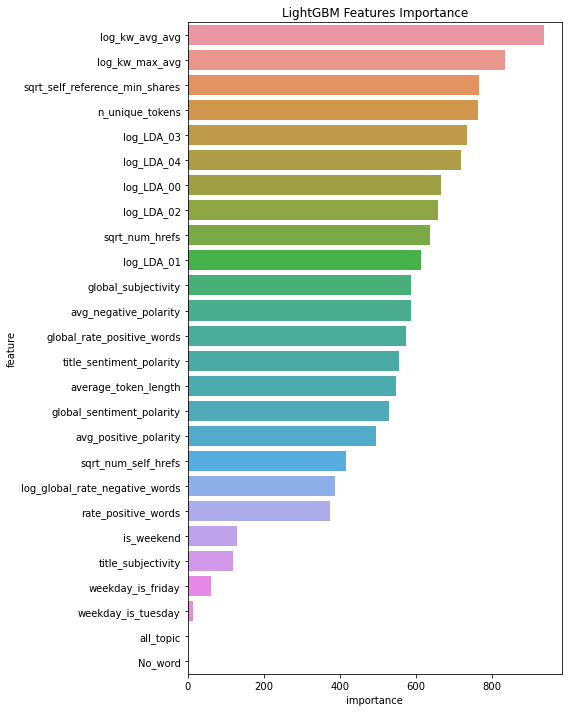

In [18]:
model = lgb.LGBMClassifier(bagging_fraction = 0.8058625936905032, 
                           bagging_freq = 6, 
                           feature_fraction = 0.9069302938359953, 
                           lambda_l1 = 45, 
                           lambda_l2 = 28, 
                           max_depth = 12, 
                           #metric = 'auc', 
                           min_split_gain = 0, 
                           num_leaves = 449, 
                           objective = 'multiclass', 
                           random_state=seed)

model.fit(X_train, y_train)

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = features
feature_importance_df["importance"] = model.feature_importances_

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features Importance')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [19]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
accuracy = accuracy_score(y_test, y_pred)
print(report)
print('auc: ', auc)
print('accuracy: ', accuracy)

              precision    recall  f1-score   support

           0       0.52      0.53      0.52      2252
           1       0.43      0.67      0.53      2829
           2       0.47      0.15      0.22      1599
           3       0.18      0.01      0.02       575

    accuracy                           0.46      7255
   macro avg       0.40      0.34      0.32      7255
weighted avg       0.45      0.46      0.42      7255

auc:  0.6680289339392873
accuracy:  0.4600964851826327


In [20]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index().drop(columns = ['index'])
feature_importance_df

,feature,importance
0,log_kw_avg_avg,936
1,log_kw_max_avg,833
2,sqrt_self_reference_min_shares,765
3,n_unique_tokens,764
4,log_LDA_03,734
5,log_LDA_04,719
6,log_LDA_00,665
7,log_LDA_02,657
8,sqrt_num_hrefs,636
9,log_LDA_01,614


## Feature Selection

In [21]:
len(feature_importance_df.feature)

26

In [22]:
feature_0 = feature_importance_df.feature[0]
model.fit(X_train[[feature_0]], y_train)
score_0 = accuracy_score(y_test, model.predict(X_test[[feature_0]]))

features = [feature_0]
scores = [score_0]

for feature in feature_importance_df.feature[1:]:
    features_temp = features.copy()
    features_temp.append(feature)
    model.fit(X_train[features_temp], y_train)
    score = accuracy_score(y_test, model.predict(X_test[features_temp]))
    if score > max(scores):
        features.append(feature)
        scores.append(score)
print('number of features: ', len(features))
print(features)
print(scores)

number of features:  15
['log_kw_avg_avg', 'log_kw_max_avg', 'sqrt_self_reference_min_shares', 'n_unique_tokens', 'log_LDA_03', 'log_LDA_04', 'log_LDA_00', 'log_LDA_02', 'sqrt_num_hrefs', 'log_LDA_01', 'global_rate_positive_words', 'average_token_length', 'global_sentiment_polarity', 'is_weekend', 'title_subjectivity']
[0.3943487250172295, 0.40151619572708475, 0.41047553411440385, 0.41764300482425915, 0.4219159200551344, 0.42605099931082013, 0.4372157133011716, 0.44024810475534115, 0.4406616126809097, 0.44589937973811167, 0.4460372157133012, 0.44645072363886973, 0.44865609924190214, 0.4587181254307374, 0.46064782908339075]


Text(0, 0.5, 'accuracy score')

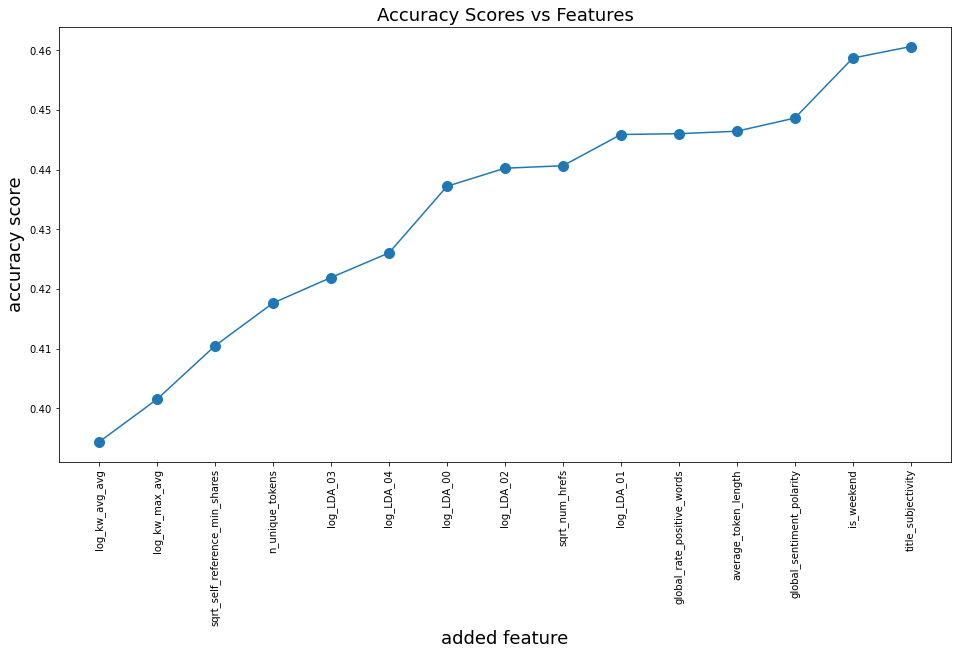

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(range(len(features)), scores, marker = '.', markersize = 20)
ax.set_title("Accuracy Scores vs Features", fontsize=18)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features,rotation=90)
ax.set_xlabel("added feature", fontsize=18)
ax.set_ylabel("accuracy score", fontsize=18)

## Final Optimization and Final Results

In [24]:
X_train = X_train[features]
LGBM_hyperopt = hyperopt_multiclass(LGBM_param_hyperopt, X_train, y_train, num_eval, lgb.LGBMClassifier)

100%|███████████████████████████████████████████████| 10/10 [00:31<00:00,  3.16s/trial, best loss: -0.4508080256973953]


In [25]:
# The best model is
lgbm_chosen = LGBM_hyperopt[1]
print(lgbm_chosen)
print(LGBM_hyperopt[0])

{'bagging_fraction': 0.840917372537952, 'bagging_freq': 6.0, 'feature_fraction': 0.9449864348944501, 'lambda_l1': 22.0, 'lambda_l2': 38.0, 'max_depth': 10.0, 'min_split_gain': 0.0, 'num_leaves': 395.0, 'objective': 0}


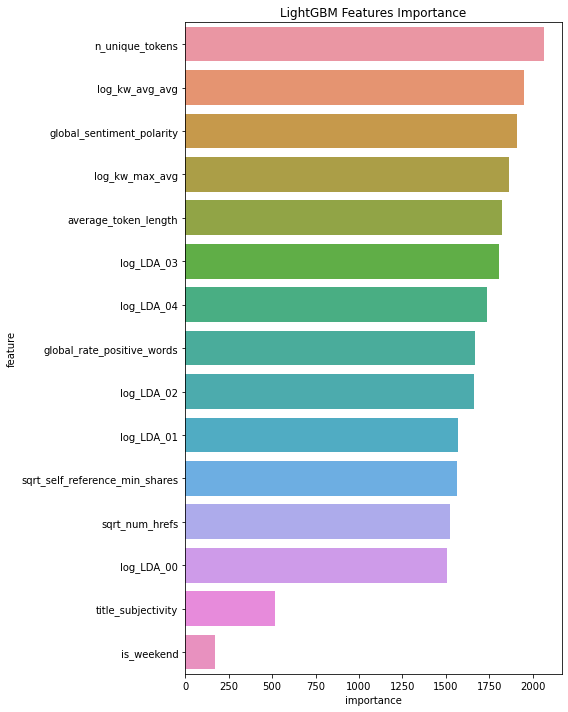

In [26]:
model = lgb.LGBMClassifier(bagging_fraction = 0.840917372537952, 
                           bagging_freq = 6, 
                           feature_fraction = 0.9449864348944501, 
                           lambda_l1 = 22, 
                           lambda_l2 = 38, 
                           max_depth = 10, 
                           #metric = 'auc', 
                           min_split_gain = 0, 
                           num_leaves = 395, 
                           objective = 'multiclass', 
                           random_state=seed)

model.fit(X_train, y_train)

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = features
feature_importance_df["importance"] = model.feature_importances_

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features Importance')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [27]:
y_pred = model.predict(X_test[features])
report = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, model.predict_proba(X_test[features]), multi_class='ovr')
accuracy = accuracy_score(y_test, y_pred)
print(report)
print('auc: ', auc)
print('accuracy: ', accuracy)

              precision    recall  f1-score   support

           0       0.52      0.53      0.52      2252
           1       0.44      0.66      0.52      2829
           2       0.45      0.18      0.25      1599
           3       0.24      0.02      0.04       575

    accuracy                           0.46      7255
   macro avg       0.41      0.35      0.34      7255
weighted avg       0.45      0.46      0.43      7255

auc:  0.6677250300916647
accuracy:  0.4614748449345279
